## MARBL diagnostics, compare timeseries of global metrics between 2 cases


In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cftime
import utils
import pandas as pd
import pop_tools
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from xgcm import Grid
xr.set_options(keep_attrs=True);

### Define cases

In [2]:
case = 'g.e30_b07.GW1850MARBL_JRA.TL319_t232_wgx3_hycom1_N75.007'
case2 = 'g.e30_b07.GW1850MARBL_JRA.TL319_t232_wgx3_hycom1_N75.009'
user = 'kristenk'

## Define the year range to examine and get the CESM history files

In [3]:
start_yr = 1
num_years = 8
endyr = start_yr + num_years 

#### first get the 3-D variables

In [4]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case}/ocn/hist/{case}.mom6.h.bgc.z.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 1 !
doing simulation year 2 !
doing simulation year 3 !
doing simulation year 4 !
doing simulation year 5 !
doing simulation year 6 !
doing simulation year 7 !
doing simulation year 8 !


In [5]:
cesm_mon_ds = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

#### Now grab the 2-D variables

In [6]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case}/ocn/hist/{case}.mom6.h.bgc.native.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 1 !
doing simulation year 2 !
doing simulation year 3 !
doing simulation year 4 !
doing simulation year 5 !
doing simulation year 6 !
doing simulation year 7 !
doing simulation year 8 !


In [7]:
cesm_mon_ds2 = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

### Keep only the variables we need (use this list for both 2-D and 3-D datasets)

In [8]:
variables2d = ['photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'CaCO3_PROD_zint','POC_FLUX_100m',
             'x_graze_microzoo_zint','x_graze_mesozoo_zint',
            'IFRAC','FG_CO2'] 

variables3d = ['SiO2_PROD','diatC', 'coccoC','spC','diazC',
            'microzooC','mesozooC','diaz_Nfix','Fe'] 


coords = {'x':'yh','y':'xh'}

### get the second case

In [9]:
start_yr = 1
num_years = 8
endyr = start_yr + num_years 

In [10]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case2}/ocn/hist/{case2}.mom6.h.bgc.z.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 1 !
doing simulation year 2 !
doing simulation year 3 !
doing simulation year 4 !
doing simulation year 5 !
doing simulation year 6 !
doing simulation year 7 !
doing simulation year 8 !


In [11]:
cesm_mon_dsB = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

In [12]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case2}/ocn/hist/{case2}.mom6.h.bgc.native.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 1 !
doing simulation year 2 !
doing simulation year 3 !
doing simulation year 4 !
doing simulation year 5 !
doing simulation year 6 !
doing simulation year 7 !
doing simulation year 8 !


In [13]:
cesm_mon_ds2B = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

### Drop unnecessary variables

In [14]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables3d + list(coords.values())
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keepthese])
cesm_mon_dsB = cesm_mon_dsB.drop([v for v in cesm_mon_dsB.variables if v not in keepthese])

In [15]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables2d + list(coords.values())
cesm_mon_ds2 = cesm_mon_ds2.drop([v for v in cesm_mon_ds2.variables if v not in keepthese])
cesm_mon_ds2B = cesm_mon_ds2B.drop([v for v in cesm_mon_ds2B.variables if v not in keepthese])

## Get the grid data for MOM6

In [16]:
ds_grid = xr.open_dataset(f'/glade/work/kristenk/cesm_work/mom6_static_files/g.e23b16.TL319_t232.GIAFMARBL.001.mom6.h.static.nc')
ds_grid2 = xr.open_dataset(f'/glade/work/kristenk/cesm_work/mom6_static_files/g.e30_b06.GJRAv4.TL319_t232_wgx3_hycom1_N75.2025.081.mom6.h.ocean_geometry.nc')

In [17]:
lons = ds_grid.geolon
lats = ds_grid.geolat
area = ds_grid.areacello #m2
depths = cesm_mon_ds.z_l

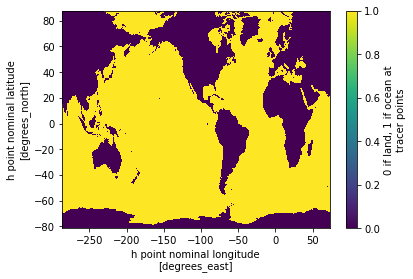

In [18]:
ds_grid.wet.plot()

#### Make my own dz variable

In [19]:
dz = np.zeros([34])

i = 0

for int in cesm_mon_ds.z_i.values[1:35]:
    
    level_up = cesm_mon_ds.z_i.values[i]
    #print(level_up,int)
    dz[i] = int - level_up

    i = i + 1

dz = xr.DataArray(dz,dims=('z_l'))

### spin up a bit of dask

In [20]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='25 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [21]:
cluster, client = get_ClusterClient()
cluster.scale(12) 
client

Client Scheduler: tcp://128.117.208.173:34647 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Make the annual mean

In [22]:
cesm_ann_ds = cesm_mon_ds.resample({'time':'A'}).mean(dim='time', keep_attrs=True).compute()

In [23]:
cesm_ann_ds2 = cesm_mon_ds2.resample({'time':'A'}).mean(dim='time', keep_attrs=True).compute()

In [24]:
cesm_ann_dsB = cesm_mon_dsB.resample({'time':'A'}).mean(dim='time', keep_attrs=True).compute()

In [25]:
cesm_ann_ds2B = cesm_mon_ds2B.resample({'time':'A'}).mean(dim='time', keep_attrs=True).compute()

### Make Global BGC metrics table

In [26]:
ds_glb = xr.Dataset()
mmols_to_PgCyr = 1e-3 * 12. * 1e-15 * 365. * 86400.

variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]
variables = variables + ['CaCO3_PROD_zint','POC_FLUX_100m','FG_CO2']
variables = variables + [f'x_graze_{zoo}_zint' for zoo in ['microzoo', 'mesozoo']]

for v in variables:
    ds_glb[v] = ((cesm_ann_ds2[v] * area).sum(dim=('xh', 'yh'))).compute() #mmol/m
    ds_glb[v].attrs = cesm_ann_ds2[v].attrs

    ds_glb[v] = ds_glb[v] * mmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

############ SiO2 production
tmp = (cesm_ann_ds.SiO2_PROD * dz).sum(dim='z_l') ## depth integral, units in mmol/m2/s
tmp = tmp * area ## mmol/s
tmp = tmp * 86400. * 365 * 0.001 ## mol/yr 
tmp = tmp.sum(dim=('xh','yh')) * 1.e-12 #Tmol/yr
ds_glb['SiO2_PROD'] = tmp.compute()
ds_glb['SiO2_PROD'].attrs['units'] = 'Tmol Si yr$^{-1}$'

######### diatom and zooplankton percents of total NPP
ds_glb['diatNPPpercent'] = ds_glb.photoC_diat_zint / ds_glb.photoC_TOT_zint * 100.
ds_glb['diatNPPpercent'].attrs['units'] = '%'

ds_glb['zooprodNPPpercent'] = (ds_glb['x_graze_mesozoo_zint'] + ds_glb['x_graze_microzoo_zint'])/ds_glb['photoC_TOT_zint'] * 100.
ds_glb['zooprodNPPpercent'].attrs['units'] = '%'

######## Nitrogen fixation
area_depth = area.where(cesm_ann_ds.SiO2_PROD > -100)
tmp = (cesm_ann_ds['diaz_Nfix'] * area_depth).sum(dim=('xh', 'yh')).compute() #mmol/m
ds_glb['diaz_Nfix'] = (tmp * dz).sum(dim='z_l') #mmol
ds_glb['diaz_Nfix'] = ds_glb['diaz_Nfix'] * 86400. * 365. * 0.001 * 14. * 1e-12 #convert to Tg N / yr
ds_glb['diaz_Nfix'].attrs['units'] = 'Tg N yr$^{-1}$'

########### total mesozoo and microzoo biomass
for zoo in ['microzooC','mesozooC','spC','coccoC','diatC','diazC']:
    tmp = ((cesm_ann_ds[zoo] * area_depth).sum(dim=('xh', 'yh'))).compute() #mmol/m
    tmp = tmp * dz #mmol
    tmp = tmp.sum(dim='z_l').values * 0.001 * 1.e-15 * 12.011 #Pg C
    ds_glb[zoo] = tmp
    ds_glb[zoo].attrs['units'] = 'Pg C'


ds_glb = ds_glb.compute()

In [27]:
ds_glbB = xr.Dataset()
mmols_to_PgCyr = 1e-3 * 12. * 1e-15 * 365. * 86400.

variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]
variables = variables + ['CaCO3_PROD_zint','POC_FLUX_100m','FG_CO2']
variables = variables + [f'x_graze_{zoo}_zint' for zoo in ['microzoo', 'mesozoo']]

for v in variables:
    ds_glbB[v] = ((cesm_ann_ds2B[v] * area).sum(dim=('xh', 'yh'))).compute() #mmol/m
    ds_glbB[v].attrs = cesm_ann_ds2B[v].attrs

    ds_glbB[v] = ds_glbB[v] * mmols_to_PgCyr        
    ds_glbB[v].attrs['units'] = 'Pg C yr$^{-1}$'

############ SiO2 production
tmp = (cesm_ann_dsB.SiO2_PROD * dz).sum(dim='z_l') ## depth integral, units in mmol/m2/s
tmp = tmp * area ## mmol/s
tmp = tmp * 86400. * 365 * 0.001 ## mol/yr 
tmp = tmp.sum(dim=('xh','yh')) * 1.e-12 #Tmol/yr
ds_glbB['SiO2_PROD'] = tmp.compute()
ds_glbB['SiO2_PROD'].attrs['units'] = 'Tmol Si yr$^{-1}$'

######### diatom and zooplankton percents of total NPP
ds_glbB['diatNPPpercent'] = ds_glbB.photoC_diat_zint / ds_glbB.photoC_TOT_zint * 100.
ds_glbB['diatNPPpercent'].attrs['units'] = '%'

ds_glbB['zooprodNPPpercent'] = (ds_glbB['x_graze_mesozoo_zint'] + ds_glbB['x_graze_microzoo_zint'])/ds_glbB['photoC_TOT_zint'] * 100.
ds_glbB['zooprodNPPpercent'].attrs['units'] = '%'

######## Nitrogen fixation
area_depth = area.where(cesm_ann_dsB.SiO2_PROD > -100)
tmp = (cesm_ann_dsB['diaz_Nfix'] * area_depth).sum(dim=('xh', 'yh')).compute() #mmol/m
ds_glbB['diaz_Nfix'] = (tmp * dz).sum(dim='z_l') #mmol
ds_glbB['diaz_Nfix'] = ds_glbB['diaz_Nfix'] * 86400. * 365. * 0.001 * 14. * 1e-12 #convert to Tg N / yr
ds_glbB['diaz_Nfix'].attrs['units'] = 'Tg N yr$^{-1}$'

########### total mesozoo and microzoo biomass
for zoo in ['microzooC','mesozooC','spC','coccoC','diatC','diazC']:
    tmp = ((cesm_ann_dsB[zoo] * area_depth).sum(dim=('xh', 'yh'))).compute() #mmol/m
    tmp = tmp * dz #mmol
    tmp = tmp.sum(dim='z_l').values * 0.001 * 1.e-15 * 12.011 #Pg C
    ds_glbB[zoo] = tmp
    ds_glbB[zoo].attrs['units'] = 'Pg C'


ds_glbB = ds_glbB.compute()

### Make some timeseries plots

In [28]:
years = np.arange(1,len(ds_glb.time)+1,1)
yearsB = np.arange(1,len(ds_glbB.time)+1,1)

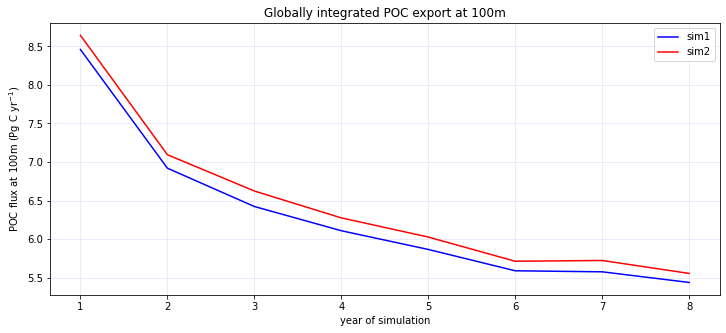

In [29]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Globally integrated POC export at 100m')
ax.plot(years,ds_glb['POC_FLUX_100m'],color='blue',label='sim1')
ax.plot(yearsB,ds_glbB['POC_FLUX_100m'],color='red',label='sim2')
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.legend()
ax.set(ylabel='POC flux at 100m (Pg C yr$^{-1}$)',xlabel='year of simulation');

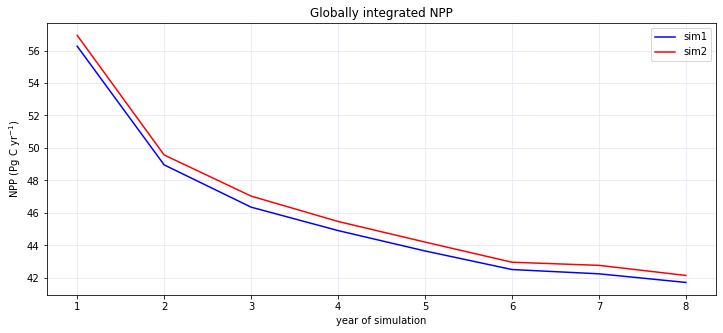

In [30]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Globally integrated NPP')
ax.plot(years,ds_glb['photoC_TOT_zint'],color='blue',label='sim1')
ax.plot(yearsB,ds_glbB['photoC_TOT_zint'],color='red',label='sim2')
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.legend()
ax.set(ylabel='NPP (Pg C yr$^{-1}$)',xlabel='year of simulation');

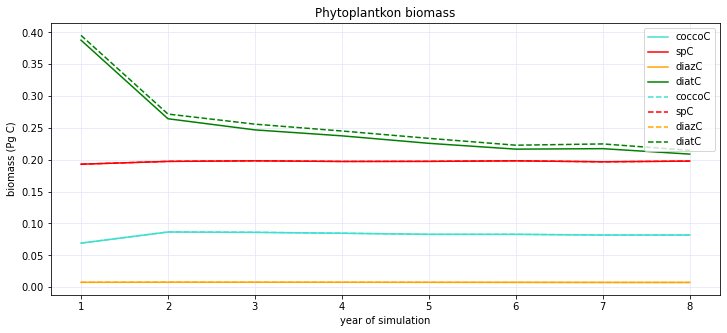

In [31]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Phytoplantkon biomass')
ax.plot(years,ds_glb['coccoC'],color='turquoise', label='coccoC')
ax.plot(years,ds_glb['spC'],color='red', label='spC')
ax.plot(years,ds_glb['diazC'],color='orange', label='diazC')
ax.plot(years,ds_glb['diatC'],color='green', label='diatC')

ax.plot(yearsB,ds_glbB['coccoC'],color='turquoise', label='coccoC',linestyle='--')
ax.plot(yearsB,ds_glbB['spC'],color='red', label='spC',linestyle='--')
ax.plot(yearsB,ds_glbB['diazC'],color='orange', label='diazC',linestyle='--')
ax.plot(yearsB,ds_glbB['diatC'],color='green', label='diatC',linestyle='--')
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.legend()
ax.set(ylabel='biomass (Pg C)',xlabel='year of simulation');

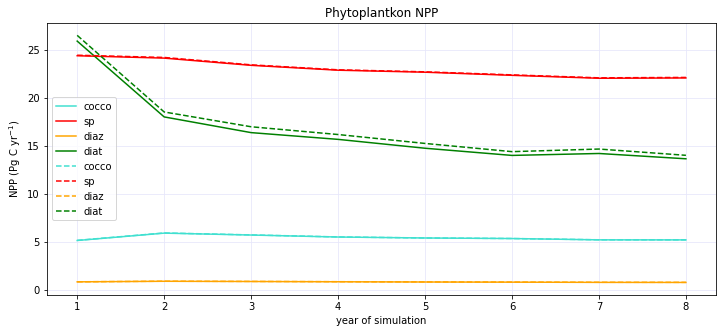

In [32]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Phytoplantkon NPP')
ax.plot(years,ds_glb['photoC_cocco_zint'],color='turquoise', label='cocco')
ax.plot(years,ds_glb['photoC_sp_zint'],color='red', label='sp')
ax.plot(years,ds_glb['photoC_diaz_zint'],color='orange', label='diaz')
ax.plot(years,ds_glb['photoC_diat_zint'],color='green', label='diat')

ax.plot(yearsB,ds_glbB['photoC_cocco_zint'],color='turquoise', label='cocco',linestyle='--')
ax.plot(yearsB,ds_glbB['photoC_sp_zint'],color='red', label='sp',linestyle='--')
ax.plot(yearsB,ds_glbB['photoC_diaz_zint'],color='orange', label='diaz',linestyle='--')
ax.plot(yearsB,ds_glbB['photoC_diat_zint'],color='green', label='diat',linestyle='--')
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.legend()
ax.set(ylabel='NPP (Pg C yr$^{-1}$)',xlabel='year of simulation');

In [33]:
diat_diff = cesm_ann_dsB.diatC.isel(z_l=0,time=len(yearsB)-1) - cesm_ann_ds.diatC.isel(z_l=0,time=len(years)-1)

In [34]:
yearsB-1

array([0, 1, 2, 3, 4, 5, 6, 7])

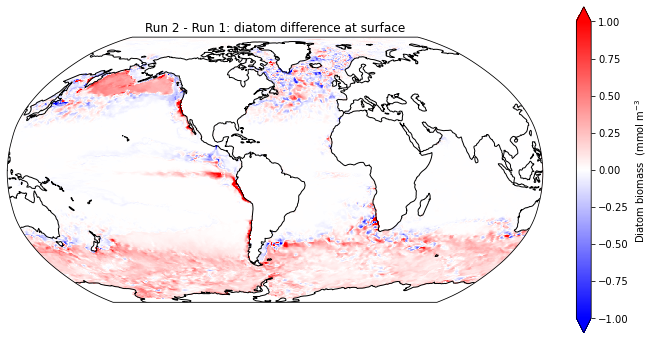

In [35]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Run 2 - Run 1: diatom difference at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, diat_diff, cmap='bwr',vmin=-1,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Diatom biomass  (mmol m$^{-3}$')

In [36]:
mesozoo_diff = cesm_ann_dsB.mesozooC.isel(z_l=0,time=len(yearsB)-1) - cesm_ann_ds.mesozooC.isel(z_l=0,time=len(years)-1)

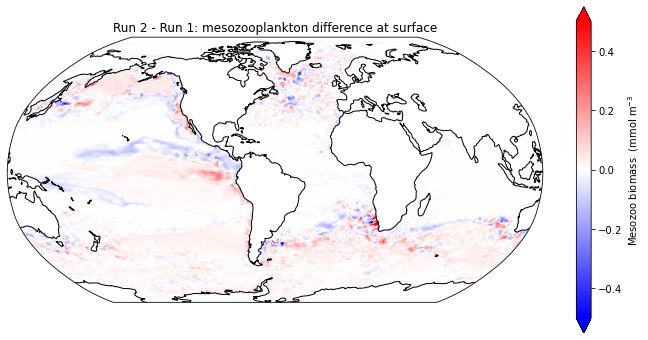

In [37]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Run 2 - Run 1: mesozooplankton difference at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, mesozoo_diff, cmap='bwr',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mesozoo biomass  (mmol m$^{-3}$')

### Table

In [38]:
ds_glb.microzooC

<xarray.DataArray 'microzooC' (microzooC: 8)>
array([0.220306, 0.23711 , 0.232379, 0.228378, 0.225979, 0.223058, 0.22036 ,
       0.220675])
Coordinates:
  * microzooC  (microzooC) float64 0.2203 0.2371 0.2324 ... 0.2231 0.2204 0.2207
Attributes:
    units:    Pg C

In [39]:
np.round(ds_glb.microzooC[-2:].mean(dim='microzooC').values, 2)

0.22

In [40]:
df = pd.DataFrame(columns=['Metric','unit','CESM baseline','CESM test','Obs','Reference'])


df.loc[0] = ['NPP',ds_glb.photoC_TOT_zint.attrs['units'],np.round(ds_glb.photoC_TOT_zint[-2:].mean(dim='time').values, 2),np.round(ds_glbB.photoC_TOT_zint[-2:].mean(dim='time').values, 2),'45 to 55','Behrenfeld & Falkowski 1997; Carr et al., 2006']
df.loc[1] = ['POC export 100m',ds_glb.POC_FLUX_100m.attrs['units'],np.round(ds_glb.POC_FLUX_100m[-2:].mean(dim='time').values, 2),np.round(ds_glbB.POC_FLUX_100m[-2:].mean(dim='time').values, 2),'4 to 12','DeVries & Weber, 2017']
df.loc[2] = ['air-sea CO2 flux',ds_glb.FG_CO2.attrs['units'],np.round(ds_glb.FG_CO2[-2:].mean(dim='time').values, 2),np.round(ds_glbB.FG_CO2[-2:].mean(dim='time').values, 2),'around 0','(for preindustrial run; negative = into ocean)']
df.loc[3] = ['%NPP by diatoms',ds_glb.diatNPPpercent.attrs['units'],np.round(ds_glb.diatNPPpercent[-2:].mean(dim='time').values, 2),np.round(ds_glbB.diatNPPpercent[-2:].mean(dim='time').values, 2),'40%','Nelson et al., 1995']
df.loc[4] = ['Silicification',ds_glb.SiO2_PROD.attrs['units'],np.round(ds_glb.SiO2_PROD[-2:].mean(dim='time').values, 2),np.round(ds_glbB.SiO2_PROD[-2:].mean(dim='time').values, 2),'100 to 190','Nelson et al., 1995; Holzer et al., 2014']
df.loc[5] = ['Calcification',ds_glb.CaCO3_PROD_zint.attrs['units'],np.round(ds_glb.CaCO3_PROD_zint[-2:].mean(dim='time').values, 2),np.round(ds_glbB.CaCO3_PROD_zint[-2:].mean(dim='time').values, 2),'0.7 to 4.7','Liang et al., 2023; Ziveri et al., 2023 and refs therein']
df.loc[6] = ['Nitrogen fixation',ds_glb.diaz_Nfix.attrs['units'],np.round(ds_glb.diaz_Nfix[-2:].mean(dim='time').values, 2),np.round(ds_glbB.diaz_Nfix[-2:].mean(dim='time').values, 2),'125.6 and 222.9','Wang et al., 2019']
df.loc[7] = ['Microzooplankton biomass',ds_glb.microzooC.attrs['units'],np.round(ds_glb.microzooC[-2:].mean(dim='microzooC').values, 2),np.round(ds_glbB.microzooC[-2:].mean(dim='microzooC').values, 2),'0.24','Buitenhuis et al., 2010']
df.loc[8] = ['Mesozooplankton biomass',ds_glb.mesozooC.attrs['units'],np.round(ds_glb.mesozooC[-2:].mean(dim='mesozooC').values, 2),np.round(ds_glbB.mesozooC[-2:].mean(dim='mesozooC').values, 2),'0.16 to 0.19','Buitenhuis et al., 2006; Moriarty & OBrien, 2013']
df.loc[9] = ['Zoo prod % of NPP',ds_glb.zooprodNPPpercent.attrs['units'],np.round(ds_glb.zooprodNPPpercent[-2:].mean(dim='time').values, 2),np.round(ds_glbB.zooprodNPPpercent[-2:].mean(dim='time').values, 2),'at least 21%','Landry and Calbet, 2004']
df

,Metric,unit,CESM baseline,CESM test,Obs,Reference
0,NPP,Pg C yr$^{-1}$,41.980000,42.459999,45 to 55,"Behrenfeld & Falkowski 1997; Carr et al., 2006"
1,POC export 100m,Pg C yr$^{-1}$,5.510000,5.640000,4 to 12,"DeVries & Weber, 2017"
2,air-sea CO2 flux,Pg C yr$^{-1}$,-0.470000,-0.380000,around 0,(for preindustrial run; negative = into ocean)
3,%NPP by diatoms,%,33.169998,33.770000,40%,"Nelson et al., 1995"
4,Silicification,Tmol Si yr$^{-1}$,109.820000,111.940000,100 to 190,"Nelson et al., 1995; Holzer et al., 2014"
5,Calcification,Pg C yr$^{-1}$,1.280000,1.280000,0.7 to 4.7,"Liang et al., 2023; Ziveri et al., 2023 and re..."
6,Nitrogen fixation,Tg N yr$^{-1}$,147.540000,149.780000,125.6 and 222.9,"Wang et al., 2019"
7,Microzooplankton biomass,Pg C,0.220000,0.220000,0.24,"Buitenhuis et al., 2010"
8,Mesozooplankton biomass,Pg C,0.280000,0.290000,0.16 to 0.19,"Buitenhuis et al., 2006; Moriarty & OBrien, 2013"
9,Zoo prod % of NPP,%,23.389999,23.230000,at least 21%,"Landry and Calbet, 2004"
